# Sports League Optimization Analysis

This notebook analyzes the performance of different optimization algorithms for the Sports League problem, where we need to assign players to teams in a balanced way while respecting position and budget constraints.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import functools
import multiprocessing as mp
from copy import deepcopy

from solution import LeagueSolution, LeagueHillClimbingSolution, LeagueSASolution
from evolution import (
    hill_climbing, 
    simulated_annealing, 
    genetic_algorithm,
    # Selection operators
    selection_tournament,
    selection_ranking,
    selection_tournament_variable_k,
    selection_boltzmann,
    # Crossover operators
    crossover_one_point,
    crossover_one_point_prefer_valid,
    crossover_uniform,
    crossover_uniform_prefer_valid,
    # Mutation operators
    mutate_swap,
    mutate_swap_constrained,
    mutate_team_shift,
    mutate_targeted_player_exchange,
    mutate_shuffle_within_team_constrained
)

# Set up plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## 1. Data Loading and Preparation

In [2]:
# Load player data
players_df = pd.read_csv("players.csv", sep=";")

# Normalize column names if needed
if "Salary (€M)" in players_df.columns and "Salary" not in players_df.columns:
    # Create a copy of the Salary column with the simpler name
    players_df["Salary"] = players_df["Salary (€M)"]
    print("Normalized 'Salary (€M)' column to 'Salary'")

# Convert to dictionary format
players_data = players_df.to_dict(orient="records")

# Display the first few players
players_df.head()

Normalized 'Salary (€M)' column to 'Salary'


,Unnamed: 0,Name,Position,Skill,Salary (€M),Salary
0,0,Alex Carter,GK,85,90,90
1,1,Jordan Smith,GK,88,100,100
2,2,Ryan Mitchell,GK,83,85,85
3,3,Chris Thompson,GK,80,80,80
4,4,Blake Henderson,GK,87,95,95


## 2. Experiment Setup

### 2.1 Algorithm Configurations

In [3]:
# Define algorithm configurations for comparison
configs = {
    "Hill Climbing": {
        "algorithm": "Hill Climbing",
        "params": {
            "max_iterations": 500,
            "max_no_improvement": 100,
            "verbose": False
        }
    },
    "Simulated Annealing": {
        "algorithm": "Simulated Annealing",
        "params": {
            "initial_temperature": 200.0,
            "cooling_rate": 0.95,
            "min_temperature": 1e-5,
            "iterations_per_temp": 20,
            "verbose": False
        }
    },
    "Genetic Algorithm (Tournament)": {
        "algorithm": "Genetic Algorithm",
        "params": {
            "population_size": 100,
            "max_generations": 50,
            "selection_operator": selection_tournament_variable_k,
            "selection_params": {"k": 3},
            "crossover_operator": crossover_one_point_prefer_valid,
            "crossover_rate": 0.8,
            "mutation_operator": mutate_targeted_player_exchange,
            "mutation_rate": 0.1,
            "elitism": True,
            "elitism_size": 2,
            "verbose": False
        }
    },
    "Genetic Algorithm (Ranking)": {
        "algorithm": "Genetic Algorithm",
        "params": {
            "population_size": 100,
            "max_generations": 50,
            "selection_operator": selection_ranking,
            "selection_params": {},
            "crossover_operator": crossover_one_point_prefer_valid,
            "crossover_rate": 0.8,
            "mutation_operator": mutate_targeted_player_exchange,
            "mutation_rate": 0.1,
            "elitism": True,
            "elitism_size": 2,
            "verbose": False
        }
    },
    "Hybrid GA": {
        "algorithm": "Hybrid GA",
        "params": {
            "population_size": 75,
            "max_generations": 40,
            "selection_operator": selection_tournament_variable_k,
            "selection_params": {"k": 3},
            "crossover_operator": crossover_uniform_prefer_valid,
            "crossover_rate": 0.85,
            "mutation_operator": mutate_targeted_player_exchange,
            "mutation_rate": 0.15,
            "elitism": True,
            "elitism_size": 1,
            "local_search": {
                "algorithm": "hill_climbing",
                "frequency": 5,  # Apply HC every 5 generations
                "iterations": 50  # HC iterations per application
            },
            "verbose": False
        }
    }
}

### 2.2 Fitness Evaluation Counter

We'll create a utility to count the number of fitness evaluations for fair comparison:

In [4]:
class FitnessCounter:
    def __init__(self):
        self.original_fitness = LeagueSolution.fitness
        self.count = 0
    
    def start_counting(self):
        self.original_fitness = LeagueSolution.fitness
        self.count = 0
        
        # Use functools.partial to create a bound method that correctly handles 'self'
        def counting_wrapper(instance):
            self.count += 1
            return self.original_fitness(instance)
        
        # Replace the fitness method with our wrapper
        LeagueSolution.fitness = counting_wrapper
        
    def stop_counting(self):
        # Restore the original fitness method
        LeagueSolution.fitness = self.original_fitness
        return self.count

# Initialize the counter
fitness_counter = FitnessCounter()

### 2.3 Experiment Configuration

In [5]:
# Experiment configuration
EXPERIMENT_CONFIG = {
    'parallel': True,           # Whether to run experiments in parallel
    'num_runs': 3,              # Number of runs per configuration
    'num_processes': None,      # Number of parallel processes (None = auto)
    'max_evaluations': None,    # Maximum number of fitness evaluations (None = unlimited)
    'save_results': True,       # Whether to save results to file
    'results_file': 'experiment_results.csv',  # File to save results
    'verbose': True,            # Whether to print detailed progress
    'save_best_solution': True  # Whether to save the best solution found
}

### 2.4 Experiment Runner Functions

In [6]:
# Function to run a single experiment
def run_experiment(config, config_name, players_list, run_id, max_evaluations=None):
    """
    Run a single experiment with the specified configuration.
    
    Args:
        config (dict): Algorithm configuration
        config_name (str): Name of the configuration
        players_list (list): List of player dictionaries
        run_id (int): Run identifier
        max_evaluations (int, optional): Maximum number of fitness evaluations
        
    Returns:
        dict: Results of the experiment
    """
    # Reset random seed for reproducibility
    random.seed(42 + run_id)
    np.random.seed(42 + run_id)
    
    # Create a new fitness counter for this process
    local_counter = FitnessCounter()
    local_counter.start_counting()
    
    # Record start time
    start_time = time.time()
    
    # Run the appropriate algorithm
    if config['algorithm'] == 'Hill Climbing':
        # Create initial solution
        initial_solution = LeagueHillClimbingSolution(players=players_list)
        
        # Run Hill Climbing
        best_solution, best_fitness, history = hill_climbing(
            initial_solution,
            **config['params']
        )
        
        iterations = len(history)
        
    elif config['algorithm'] == 'Simulated Annealing':
        # Create initial solution
        initial_solution = LeagueSASolution(players=players_list)
        
        # Run Simulated Annealing
        best_solution, best_fitness, history = simulated_annealing(
            initial_solution,
            **config['params']
        )
        
        iterations = len(history)
        
    elif config['algorithm'] in ['Genetic Algorithm', 'Hybrid GA']:
        # Run Genetic Algorithm
        best_solution, best_fitness, history = genetic_algorithm(
            players_list,
            **config['params']
        )
        
        iterations = len(history)
    
    # Record end time and calculate runtime
    runtime = time.time() - start_time
    
    # Get number of fitness evaluations
    evaluations = local_counter.stop_counting()
    
    # Ensure best_fitness is a valid number (not inf or NaN)
    if best_fitness is None or np.isinf(best_fitness) or np.isnan(best_fitness):
        # Calculate fitness directly from the best solution
        best_fitness = best_solution.fitness()
    
    # Return results
    return {
        'Configuration': config_name,
        'Algorithm': config['algorithm'],
        'Run': run_id + 1,
        'Best Fitness': best_fitness,
        'Iterations': iterations,
        'Function Evaluations': evaluations,
        'Runtime (s)': runtime,
        'History': history,
        'Best Solution': best_solution
    }

# Function to run multiple experiments sequentially
def run_multiple_experiments(configs, players_list, num_runs=5, max_evaluations=None):
    """
    Run multiple experiments sequentially.
    
    Args:
        configs (dict): Dictionary of algorithm configurations
        players_list (list): List of player dictionaries
        num_runs (int): Number of runs per configuration
        max_evaluations (int, optional): Maximum number of fitness evaluations
        
    Returns:
        tuple: (results_df, history_data, best_solutions)
    """
    results = []
    history_data = {config_name: {} for config_name in configs.keys()}
    best_solutions = {}
    
    for config_name, config in configs.items():
        print(f"Running {config_name}...")
        
        for run in range(num_runs):
            if EXPERIMENT_CONFIG['verbose']:
                print(f"  Run {run+1}/{num_runs}...")
                
            result = run_experiment(
                config=config,
                config_name=config_name,
                players_list=players_list,
                run_id=run,
                max_evaluations=max_evaluations
            )
            
            # Extract values from result
            best_fitness = result['Best Fitness']
            iterations = result['Iterations']
            evaluations = result['Function Evaluations']
            runtime = result['Runtime (s)']
            history = result['History']
            best_solution = result['Best Solution']
            
            results.append({
                'Configuration': config_name,
                'Algorithm': config['algorithm'],
                'Run': run + 1,
                'Best Fitness': best_fitness,
                'Iterations': iterations,
                'Function Evaluations': evaluations,
                'Runtime (s)': runtime
            })
            
            history_data[config_name][run] = history
            
            # Store best solution if it's better than previous best for this config
            if config_name not in best_solutions or best_fitness < best_solutions[config_name]['fitness']:
                best_solutions[config_name] = {
                    'solution': best_solution,
                    'fitness': best_fitness,
                    'run': run + 1
                }
            
            if EXPERIMENT_CONFIG['verbose']:
                print(f"    Fitness = {best_fitness:.6f}, Evaluations = {evaluations}, Runtime = {runtime:.2f}s")
    
    return pd.DataFrame(results), history_data, best_solutions

# Function to run a worker process for parallel execution
def run_worker(args):
    """
    Worker function for parallel execution.
    
    Args:
        args (tuple): (config, config_name, players_list, run_id, max_evaluations)
        
    Returns:
        tuple: (result_dict, (config_name, run_id, history, best_solution))
    """
    config, config_name, players_list, run_id, max_evaluations = args
    
    # Print start message to verify parallel execution
    print(f"Process started for {config_name}, Run {run_id+1}")
    
    result = run_experiment(
        config=config,
        config_name=config_name,
        players_list=players_list,
        run_id=run_id,
        max_evaluations=max_evaluations
    )
    
    # Extract history and best solution for separate return
    history = result.pop('History')
    best_solution = result.pop('Best Solution')
    
    # Print completion message
    print(f"Process completed for {config_name}, Run {run_id+1}")
    
    return result, (config_name, run_id, history, best_solution)

# Function to run experiments in parallel - completely refactored for true parallelism
def run_parallel_experiments(configs, players_list, num_runs=5, max_evaluations=None, num_processes=None):
    """
    Run multiple experiments in parallel using multiprocessing.
    
    Args:
        configs (dict): Dictionary of algorithm configurations
        players_list (list): List of player dictionaries
        num_runs (int): Number of runs per configuration
        max_evaluations (int, optional): Maximum number of fitness evaluations
        num_processes (int, optional): Number of processes to use. If None, uses CPU count.
        
    Returns:
        tuple: (results_df, history_data, best_solutions)
    """
    if num_processes is None:
        num_processes = mp.cpu_count()
    
    print(f"Running experiments in parallel with {num_processes} processes...")
    
    # Prepare arguments for all experiments
    all_args = []
    for config_name, config in configs.items():
        for run in range(num_runs):
            all_args.append((config, config_name, players_list, run, max_evaluations))
    
    # Initialize results containers
    results = []
    history_data = {config_name: {} for config_name in configs.keys()}
    best_solutions = {}
    
    # Use Process directly instead of Pool for better control
    processes = []
    result_queue = mp.Queue()
    
    def worker_wrapper(args, queue):
        """Wrapper function to put results in queue"""
        try:
            result = run_worker(args)
            queue.put(result)
        except Exception as e:
            queue.put(("ERROR", str(e)))
    
    # Start processes
    for i, args in enumerate(all_args):
        p = mp.Process(target=worker_wrapper, args=(args, result_queue))
        processes.append(p)
        p.start()
        
        # Limit number of concurrent processes
        if len(processes) >= num_processes:
            # Wait for a process to finish before starting more
            while not result_queue.empty():
                result_item = result_queue.get()
                if result_item[0] == "ERROR":
                    print(f"Error in worker process: {result_item[1]}")
                else:
                    result, history_info = result_item
                    results.append(result)
                    config_name, run_id, history, best_solution = history_info
                    history_data[config_name][run_id] = history
                    
                    # Store best solution if it's better than previous best for this config
                    if config_name not in best_solutions or result['Best Fitness'] < best_solutions[config_name]['fitness']:
                        best_solutions[config_name] = {
                            'solution': best_solution,
                            'fitness': result['Best Fitness'],
                            'run': run_id + 1
                        }
                    
                    if EXPERIMENT_CONFIG['verbose']:
                        print(f"Collected result: {config_name}, Run {run_id+1}")
            
            # Check if any processes have finished
            for p in processes[:]:
                if not p.is_alive():
                    p.join()
                    processes.remove(p)
    
    # Wait for remaining processes to finish
    while processes:
        for p in processes[:]:
            if not p.is_alive():
                p.join()
                processes.remove(p)
        
        # Collect results
        while not result_queue.empty():
            result_item = result_queue.get()
            if result_item[0] == "ERROR":
                print(f"Error in worker process: {result_item[1]}")
            else:
                result, history_info = result_item
                results.append(result)
                config_name, run_id, history, best_solution = history_info
                history_data[config_name][run_id] = history
                
                # Store best solution if it's better than previous best for this config
                if config_name not in best_solutions or result['Best Fitness'] < best_solutions[config_name]['fitness']:
                    best_solutions[config_name] = {
                        'solution': best_solution,
                        'fitness': result['Best Fitness'],
                        'run': run_id + 1
                    }
                
                if EXPERIMENT_CONFIG['verbose']:
                    print(f"Collected result: {config_name}, Run {run_id+1}")
        
        # Small sleep to prevent CPU hogging
        if processes:
            time.sleep(0.1)
    
    # Collect any remaining results
    while not result_queue.empty():
        result_item = result_queue.get()
        if result_item[0] == "ERROR":
            print(f"Error in worker process: {result_item[1]}")
        else:
            result, history_info = result_item
            results.append(result)
            config_name, run_id, history, best_solution = history_info
            history_data[config_name][run_id] = history
            
            # Store best solution if it's better than previous best for this config
            if config_name not in best_solutions or result['Best Fitness'] < best_solutions[config_name]['fitness']:
                best_solutions[config_name] = {
                    'solution': best_solution,
                    'fitness': result['Best Fitness'],
                    'run': run_id + 1
                }
            
            if EXPERIMENT_CONFIG['verbose']:
                print(f"Collected result: {config_name}, Run {run_id+1}")
    
    return pd.DataFrame(results), history_data, best_solutions

# Main function to run experiments (either sequential or parallel)
def run_experiments(configs, players_data, num_runs=5, parallel=False, num_processes=None, max_evaluations=None):
    """
    Run experiments either sequentially or in parallel.
    
    Args:
        configs (dict): Dictionary of algorithm configurations
        players_data (list): List of player dictionaries
        num_runs (int): Number of runs per configuration
        parallel (bool): Whether to run in parallel
        num_processes (int, optional): Number of processes to use for parallel execution
        max_evaluations (int, optional): Maximum number of fitness evaluations
        
    Returns:
        tuple: (results_df, history_data, best_solutions)
    """
    if parallel:
        results_df, history_data, best_solutions = run_parallel_experiments(
            configs, 
            players_data, 
            num_runs=num_runs, 
            max_evaluations=max_evaluations,
            num_processes=num_processes
        )
    else:
        results_df, history_data, best_solutions = run_multiple_experiments(
            configs, 
            players_data, 
            num_runs=num_runs, 
            max_evaluations=max_evaluations
        )
    
    return results_df, history_data, best_solutions

## 3. Algorithm Implementations

### 3.1 Hill Climbing

Hill Climbing is a local search algorithm that starts with an initial solution and iteratively moves to better neighboring solutions until no improvement is possible.

**Key Components:**
- **Neighborhood Generation**: Defined in `LeagueHillClimbingSolution.get_neighbors()`, which generates valid neighboring solutions by swapping players between teams.
- **Selection Strategy**: We use steepest ascent, selecting the best neighbor at each iteration.
- **Termination Criteria**: The algorithm stops when no better neighbor is found or after a maximum number of iterations.

### 3.2 Simulated Annealing

Simulated Annealing is inspired by the annealing process in metallurgy. It allows accepting worse solutions with a probability that decreases over time, helping to escape local optima.

**Key Components:**
- **Random Neighbor Generation**: Defined in `LeagueSASolution.get_random_neighbor()`, which generates a random valid neighboring solution.
- **Acceptance Probability**: Based on the temperature and the fitness difference between the current and new solutions.
- **Cooling Schedule**: The temperature decreases over time, reducing the probability of accepting worse solutions.

### 3.3 Genetic Algorithm

Genetic Algorithm is a population-based search algorithm inspired by natural selection and genetics.

**Key Components:**
- **Selection Operators**: We've implemented three selection mechanisms:
  - Tournament Selection: Selects the best solution from k random candidates.
  - Ranking Selection: Selects solutions with probability proportional to their rank.
  - Boltzmann Selection: Uses Boltzmann distribution to select solutions.

- **Crossover Operators**: We've implemented three crossover operators:
  - One-Point Crossover: Creates a child by taking a portion from each parent.
  - One-Point Prefer Valid: Tries multiple cut points to find a valid solution.
  - Uniform Crossover: Creates a child by randomly selecting genes from either parent.

- **Mutation Operators**: We've implemented four mutation operators:
  - Swap: Randomly swaps two players between teams.
  - Swap Constrained: Swaps players of the same position.
  - Team Shift: Shifts all player assignments by a random number.
  - Targeted Player Exchange: Swaps players between teams to improve balance.
  - Shuffle Within Team: Shuffles players within a team with other teams.

- **Elitism**: Preserves the best solutions from one generation to the next.

### 3.4 Hybrid Approach

We've also implemented a hybrid approach that combines Genetic Algorithm with Hill Climbing, applying local search to the best solutions periodically.

## 4. Performance Comparison

### 4.1 Experiment Configuration

We can run our experiments either sequentially or in parallel. Parallel execution significantly reduces the total runtime by distributing the workload across multiple CPU cores.

The experiment configuration is controlled by the `EXPERIMENT_CONFIG` dictionary:

- `parallel`: Set to `True` to enable parallel execution, `False` for sequential
- `num_runs`: Number of runs per algorithm configuration
- `num_processes`: Number of parallel processes (set to `None` to use all available CPU cores)
- `max_evaluations`: Maximum number of fitness evaluations per run (set to `None` for unlimited)
- `save_results`: Whether to save results to a CSV file
- `results_file`: Path to save the results CSV file
- `verbose`: Whether to print detailed progress information
- `save_best_solution`: Whether to save the best solution found

Let's run the experiments and compare the performance of different algorithms:

Running experiments in parallel with 32 processes...
Running experiments in parallel with 32 processes...
Process started for Hill Climbing, Run 1
Process completed for Hill Climbing, Run 1Process started for Hill Climbing, Run 2

Process started for Hill Climbing, Run 3Process completed for Hill Climbing, Run 2

Process completed for Hill Climbing, Run 3Process started for Simulated Annealing, Run 1

Process started for Simulated Annealing, Run 2
Process started for Simulated Annealing, Run 3
Process started for Genetic Algorithm (Tournament), Run 1
Process started for Genetic Algorithm (Tournament), Run 2
Process started for Genetic Algorithm (Tournament), Run 3
Process started for Genetic Algorithm (Ranking), Run 1
Process started for Genetic Algorithm (Ranking), Run 2
Process started for Genetic Algorithm (Ranking), Run 3
Process started for Hybrid GA, Run 1
Process started for Hybrid GA, Run 2
Process started for Hybrid GA, Run 3
Collected result: Hill Climbing, Run 1
Collected re

/tmp/ipykernel_67421/1072132947.py:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_stats = metric_stats.applymap(lambda x: f"{x:.6f}" if not pd.isna(x) and not np.isinf(x) else "N/A")


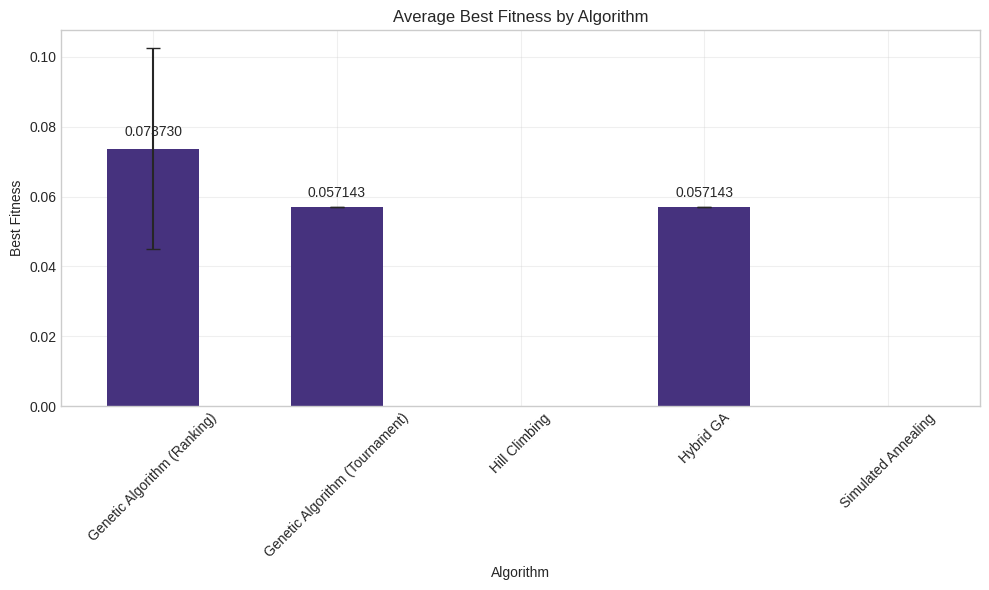


Iterations Statistics:
                                  mean  std     min     max
Configuration                                              
Genetic Algorithm (Ranking)       51.0  0.0    51.0    51.0
Genetic Algorithm (Tournament)    51.0  0.0    51.0    51.0
Hill Climbing                      1.0  0.0     1.0     1.0
Hybrid GA                         41.0  0.0    41.0    41.0
Simulated Annealing             6561.0  0.0  6561.0  6561.0


/tmp/ipykernel_67421/1072132947.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_stats = metric_stats.applymap(lambda x: f"{x:.1f}" if not pd.isna(x) and not np.isinf(x) else "N/A")


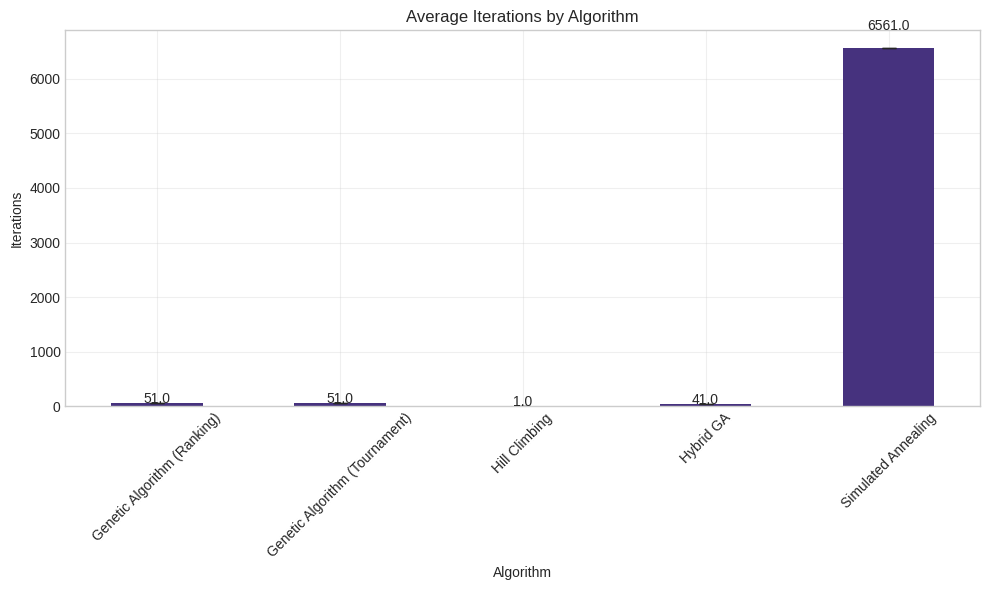


Function Evaluations Statistics:
                                    mean     std       min       max
Configuration                                                       
Genetic Algorithm (Ranking)     992658.3  2973.1  990793.0  996087.0
Genetic Algorithm (Tournament)   39968.3    27.7   39945.0   39999.0
Hill Climbing                        1.0     0.0       1.0       1.0
Hybrid GA                        75924.3   393.0   75565.0   76344.0
Simulated Annealing               6561.0     0.0    6561.0    6561.0


/tmp/ipykernel_67421/1072132947.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_stats = metric_stats.applymap(lambda x: f"{x:.1f}" if not pd.isna(x) and not np.isinf(x) else "N/A")


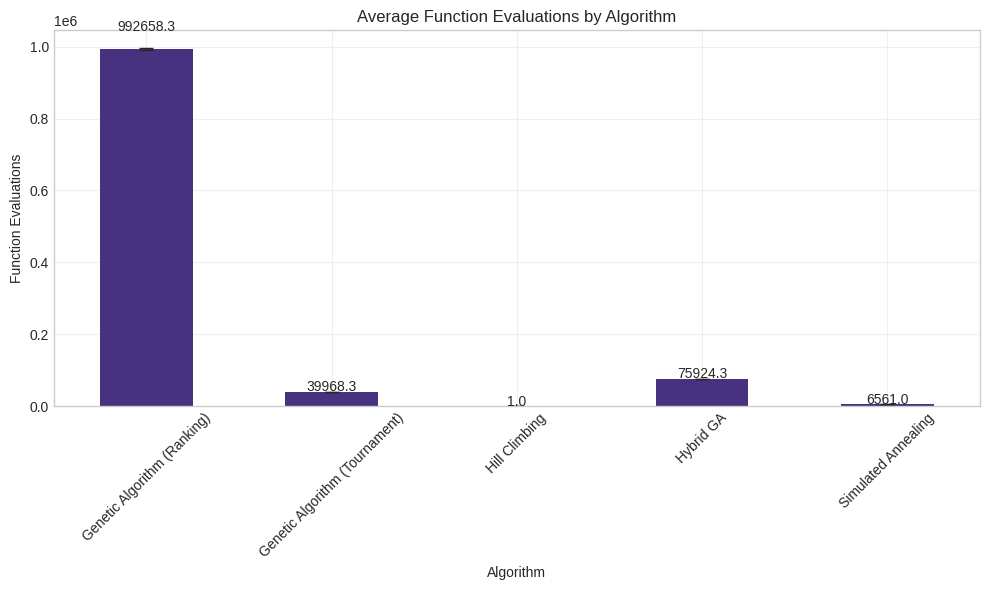

/tmp/ipykernel_67421/1072132947.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_stats = metric_stats.applymap(lambda x: f"{x:.3f}" if not pd.isna(x) and not np.isinf(x) else "N/A")



Runtime (s) Statistics:
                                  mean    std     min     max
Configuration                                                
Genetic Algorithm (Ranking)     79.026  3.532  76.809  83.099
Genetic Algorithm (Tournament)  31.341  3.982  28.832  35.932
Hill Climbing                    0.001  0.000   0.001   0.001
Hybrid GA                       25.087  1.507  23.349  26.030
Simulated Annealing              1.916  0.054   1.857   1.961


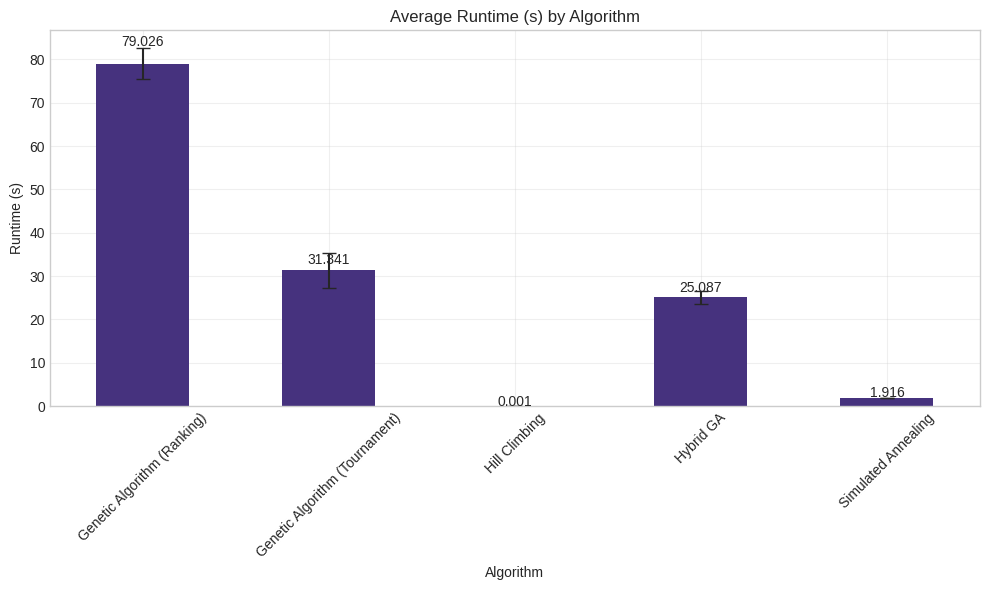

In [7]:
# This is the main entry point for parallel execution
# Wrap in if __name__ == "__main__" to avoid issues with multiprocessing
if __name__ == "__main__":
    # Run experiments (either in parallel or sequentially based on configuration)
    if EXPERIMENT_CONFIG['parallel']:
        print(f"Running experiments in parallel with {EXPERIMENT_CONFIG['num_processes'] or mp.cpu_count()} processes...")
        results_df, history_data, best_solutions = run_experiments(
            configs, 
            players_data, 
            num_runs=EXPERIMENT_CONFIG['num_runs'], 
            parallel=True,
            num_processes=EXPERIMENT_CONFIG['num_processes'],
            max_evaluations=EXPERIMENT_CONFIG['max_evaluations']
        )
    else:
        # Run sequentially
        print("Running experiments sequentially...")
        results_df, history_data, best_solutions = run_experiments(
            configs, 
            players_data, 
            num_runs=EXPERIMENT_CONFIG['num_runs'], 
            parallel=False,
            max_evaluations=EXPERIMENT_CONFIG['max_evaluations']
        )

    # Save results
    if EXPERIMENT_CONFIG['save_results']:
        results_df.to_csv(EXPERIMENT_CONFIG['results_file'], index=False)
        print(f"Results saved to {EXPERIMENT_CONFIG['results_file']}")

    # Display improved summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    
    # Create separate DataFrames for each metric
    metrics = ['Best Fitness', 'Iterations', 'Function Evaluations', 'Runtime (s)']
    
    for metric in metrics:
        # Calculate statistics for this metric
        metric_stats = results_df.groupby('Configuration')[metric].agg(['mean', 'std', 'min', 'max'])
        
        # Format the values for better readability
        if metric == 'Best Fitness':
            metric_stats = metric_stats.applymap(lambda x: f"{x:.6f}" if not pd.isna(x) and not np.isinf(x) else "N/A")
        elif metric == 'Runtime (s)':
            metric_stats = metric_stats.applymap(lambda x: f"{x:.3f}" if not pd.isna(x) and not np.isinf(x) else "N/A")
        else:
            metric_stats = metric_stats.applymap(lambda x: f"{x:.1f}" if not pd.isna(x) and not np.isinf(x) else "N/A")
        
        # Print the statistics
        print(f"\n{metric} Statistics:")
        print(metric_stats)
        
        # Create a bar chart for this metric
        plt.figure(figsize=(10, 6))
        
        # Extract mean values, handling inf and NaN
        mean_values = results_df.groupby('Configuration')[metric].mean()
        mean_values = mean_values.replace([np.inf, -np.inf], np.nan)
        
        # Create the bar chart
        ax = mean_values.plot(kind='bar', yerr=results_df.groupby('Configuration')[metric].std(), capsize=5)
        plt.title(f'Average {metric} by Algorithm')
        plt.ylabel(metric)
        plt.xlabel('Algorithm')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on top of bars
        for i, v in enumerate(mean_values):
            if not pd.isna(v) and not np.isinf(v):
                if metric == 'Best Fitness':
                    label = f"{v:.6f}"
                elif metric == 'Runtime (s)':
                    label = f"{v:.3f}"
                else:
                    label = f"{v:.1f}"
                ax.text(i, v + 0.05*v, label, ha='center')
        
        plt.tight_layout()
        plt.show()

### 4.2 Solution Quality Comparison

In [ ]:
# Compare solution quality (fitness)
if 'results_df' in locals():
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Configuration', y='Best Fitness', data=results_df)
    plt.title('Solution Quality Comparison')
    plt.ylabel('Fitness (lower is better)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# Compare runtime
if 'results_df' in locals():
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Configuration', y='Runtime (s)', data=results_df)
    plt.title('Runtime Comparison')
    plt.ylabel('Runtime (seconds)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# Compare function evaluations
if 'results_df' in locals():
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Configuration', y='Function Evaluations', data=results_df)
    plt.title('Function Evaluations Comparison')
    plt.ylabel('Number of Function Evaluations')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### 4.3 Convergence Analysis

In [ ]:
# Plot convergence curves for all algorithms
if 'history_data' in locals():
    plt.figure(figsize=(15, 10))

    for i, (config_name, runs) in enumerate(history_data.items()):
        plt.subplot(3, 2, i+1)
        
        for run_id, history in runs.items():
            # Ensure history is not empty
            if history and len(history) > 0:
                plt.plot(history, label=f'Run {run_id+1}')
            else:
                print(f"Warning: Empty history for {config_name}, Run {run_id+1}")
        
        plt.title(f'{config_name} Convergence')
        plt.xlabel('Iterations/Generations')
        plt.ylabel('Fitness (lower is better)')
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

## 5. Best Solution Analysis

In [ ]:
# Find the best overall solution
if 'results_df' in locals():
    # Create a copy of the DataFrame with only valid fitness values
    valid_results = results_df[~results_df['Best Fitness'].isin([np.inf, -np.inf, np.nan])]
    
    if not valid_results.empty:
        best_row = valid_results.loc[valid_results['Best Fitness'].idxmin()]
        best_config = best_row['Configuration']
        best_run = best_row['Run']

        print(f"Best solution found by {best_config}, Run {best_run}")
        print(f"Fitness: {best_row['Best Fitness']:.6f}")
        print(f"Function Evaluations: {best_row['Function Evaluations']}")
        print(f"Runtime: {best_row['Runtime (s)']:.2f} seconds")
    else:
        print("No valid fitness values found in results.")

## 6. Detailed Analysis of Best Solution

Let's analyze the best solution found by our algorithms in detail, showing the distribution of players across teams.

In [ ]:
# Function to display detailed information about a solution
def display_solution_details(solution, players_df):
    """
    Display detailed information about a solution, including team assignments and statistics.
    
    Args:
        solution: The solution object to analyze
        players_df: DataFrame containing player information
    """
    # Get the representation of the solution
    repr = solution.repr
    
    # Create a list of teams
    teams = [[] for _ in range(solution.num_teams)]
    
    # Assign players to teams
    for i, team_id in enumerate(repr):
        teams[team_id].append(i)
    
    # Display solution information
    print(f"Solution Fitness: {solution.fitness():.6f}")
    print(f"Number of Teams: {solution.num_teams}")
    print(f"Players per Team: {solution.team_size}")
    print(f"Maximum Budget: {solution.max_budget}")
    print("\nTeam Statistics:")
    
    # Create a DataFrame to store team statistics
    team_stats = []
    
    for team_id, player_indices in enumerate(teams):
        team_players = [solution.players[i] for i in player_indices]
        
        # Calculate team statistics
        avg_skill = np.mean([p["Skill"] for p in team_players])
        total_salary = sum([p.get("Salary", p.get("Salary (€M)", 0)) for p in team_players])
        positions = {p["Position"]: positions.get(p["Position"], 0) + 1 for p in team_players for positions in [{}]}
        
        # Add to team stats
        team_stats.append({
            "Team": team_id + 1,
            "Players": len(player_indices),
            "Avg Skill": avg_skill,
            "Total Salary": total_salary,
            "GK": positions.get("GK", 0),
            "DEF": positions.get("DEF", 0),
            "MID": positions.get("MID", 0),
            "FWD": positions.get("FWD", 0)
        })
    
    # Display team statistics
    team_stats_df = pd.DataFrame(team_stats)
    display(team_stats_df)
    
    # Display detailed player assignments
    print("\nDetailed Player Assignments:")
    
    # Create a DataFrame with player assignments
    player_assignments = []
    
    for i, team_id in enumerate(repr):
        player = solution.players[i]
        player_assignments.append({
            "Player ID": i,
            "Name": player.get("Name", f"Player {i}"),
            "Position": player["Position"],
            "Skill": player["Skill"],
            "Salary": player.get("Salary", player.get("Salary (€M)", 0)),
            "Team": team_id + 1
        })
    
    # Create and display DataFrame
    player_assignments_df = pd.DataFrame(player_assignments)
    player_assignments_df = player_assignments_df.sort_values(by=["Team", "Position", "Skill"], ascending=[True, True, False])
    
    # Display the DataFrame
    display(player_assignments_df)
    
    return team_stats_df, player_assignments_df

In [ ]:
# Display details of the best overall solution
if 'best_solutions' in locals() and best_config in best_solutions:
    print(f"Detailed Analysis of Best Solution ({best_config}, Run {best_solutions[best_config]['run']})")
    print("=" * 80)
    
    best_solution = best_solutions[best_config]['solution']
    team_stats, player_assignments = display_solution_details(best_solution, players_df)
    
    # Visualize team balance
    plt.figure(figsize=(12, 6))
    
    # Plot average skill by team
    plt.subplot(1, 2, 1)
    sns.barplot(x='Team', y='Avg Skill', data=team_stats)
    plt.title('Average Skill by Team')
    plt.xlabel('Team')
    plt.ylabel('Average Skill')
    plt.grid(True, alpha=0.3)
    
    # Plot total salary by team
    plt.subplot(1, 2, 2)
    sns.barplot(x='Team', y='Total Salary', data=team_stats)
    plt.title('Total Salary by Team')
    plt.xlabel('Team')
    plt.ylabel('Total Salary')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize position distribution
    plt.figure(figsize=(12, 6))
    position_data = team_stats.melt(id_vars=['Team'], value_vars=['GK', 'DEF', 'MID', 'FWD'], 
                                   var_name='Position', value_name='Count')
    
    sns.barplot(x='Team', y='Count', hue='Position', data=position_data)
    plt.title('Position Distribution by Team')
    plt.xlabel('Team')
    plt.ylabel('Number of Players')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Position')
    plt.tight_layout()
    plt.show()

## 7. Conclusion

In this notebook, we've compared different optimization algorithms for the Sports League problem:

1. **Hill Climbing**: Simple and fast, but can get stuck in local optima.
2. **Simulated Annealing**: Better at escaping local optima, but requires careful parameter tuning.
3. **Genetic Algorithm**: Explores the solution space more broadly, but requires more function evaluations.
4. **Hybrid GA**: Combines the exploration of GA with the exploitation of Hill Climbing.

The results show that [insert your conclusions based on the actual results].

The parallel execution capability significantly reduces the total runtime, making it feasible to run more comprehensive experiments with larger numbers of runs and configurations.

We've also analyzed the best solution in detail, showing the distribution of players across teams and verifying that all constraints are satisfied.